# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0820"     # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(966, 32, 20, 3)
(966, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
242/242 [==============================] - 2s 7ms/step - loss: 1.9386 - accuracy: 0.4234 - val_loss: 1.3341 - val_accuracy: 0.6031
Epoch 2/400
242/242 [==============================] - 2s 7ms/step - loss: 1.1175 - accuracy: 0.6522 - val_loss: 0.7888 - val_accuracy: 0.7577
Epoch 3/400
242/242 [==============================] - 2s 7ms/step - loss: 0.7479 - accuracy: 0.7692 - val_loss: 0.7306 - val_accuracy: 0.7835
Epoch 4/400
242/242 [==============================] - 3s 10ms/step - loss: 0.5970 - accuracy: 0.8188 - val_loss: 0.6672 - val_accuracy: 0.7784
Epoch 5/400
242/242 [==============================] - 2s 10ms/step - loss: 0.4958 - accuracy: 0.8540 - val_loss: 0.4479 - val_accuracy: 0.8763
Epoch 6/400
242/242 [==============================] - 2s 10ms/step - loss: 0.4875 - accuracy: 0.8582 - val_loss: 0.4010 - val_accuracy: 0.8505
Epoch 7/400
242/242 [==============================] - 3s 11ms/

242/242 [==============================] - 4s 17ms/step - loss: 0.0842 - accuracy: 0.9803 - val_loss: 0.0887 - val_accuracy: 0.9845
Epoch 56/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0574 - accuracy: 0.9814 - val_loss: 0.0439 - val_accuracy: 0.9845
Epoch 57/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0974 - val_accuracy: 0.9691
Epoch 58/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0849 - accuracy: 0.9731 - val_loss: 0.0783 - val_accuracy: 0.9691
Epoch 59/400
242/242 [==============================] - 4s 16ms/step - loss: 0.1001 - accuracy: 0.9762 - val_loss: 0.0735 - val_accuracy: 0.9845
Epoch 60/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0817 - accuracy: 0.9803 - val_loss: 0.1603 - val_accuracy: 0.9742
Epoch 61/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0714 - accuracy: 0.9845 - val_loss: 0.0562 - val_accuracy: 0.969

242/242 [==============================] - 3s 14ms/step - loss: 0.0726 - accuracy: 0.9845 - val_loss: 0.0431 - val_accuracy: 0.9845
Epoch 112/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0512 - accuracy: 0.9865 - val_loss: 0.0375 - val_accuracy: 0.9845
Epoch 113/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0435 - accuracy: 0.9876 - val_loss: 0.0291 - val_accuracy: 0.9897
Epoch 114/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0355 - accuracy: 0.9865 - val_loss: 0.0801 - val_accuracy: 0.9845
Epoch 115/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0500 - accuracy: 0.9855 - val_loss: 0.0523 - val_accuracy: 0.9845
Epoch 116/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0555 - accuracy: 0.9824 - val_loss: 0.0620 - val_accuracy: 0.9794
Epoch 117/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0483 - accuracy: 0.9876 - val_loss: 0.0516 - val_accuracy:

242/242 [==============================] - 3s 14ms/step - loss: 0.0518 - accuracy: 0.9886 - val_loss: 0.0160 - val_accuracy: 0.9948
Epoch 168/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0371 - accuracy: 0.9907 - val_loss: 0.0329 - val_accuracy: 0.9948
Epoch 169/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0341 - accuracy: 0.9917 - val_loss: 0.0279 - val_accuracy: 0.9948
Epoch 170/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 6.7427e-04 - val_accuracy: 1.0000
Epoch 171/400
242/242 [==============================] - 4s 15ms/step - loss: 0.0596 - accuracy: 0.9845 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 172/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0173 - accuracy: 0.9907 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 173/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0478 - accuracy: 0.9907 - val_loss: 0.0164 - val_accur

242/242 [==============================] - 3s 14ms/step - loss: 0.0620 - accuracy: 0.9876 - val_loss: 0.0200 - val_accuracy: 0.9948
Epoch 224/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0203 - accuracy: 0.9917 - val_loss: 0.0340 - val_accuracy: 0.9845
Epoch 225/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0576 - accuracy: 0.9886 - val_loss: 0.0140 - val_accuracy: 0.9948
Epoch 226/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0150 - val_accuracy: 0.9948
Epoch 227/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0187 - accuracy: 0.9948 - val_loss: 0.0077 - val_accuracy: 0.9948
Epoch 228/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0319 - accuracy: 0.9928 - val_loss: 0.0281 - val_accuracy: 0.9948
Epoch 229/400
242/242 [==============================] - 3s 14ms/step - loss: 0.0415 - accuracy: 0.9896 - val_loss: 0.0108 - val_accuracy:

242/242 [==============================] - 3s 11ms/step - loss: 0.0062 - accuracy: 0.9959 - val_loss: 0.0246 - val_accuracy: 0.9897
Epoch 280/400
242/242 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9917 - val_loss: 1.4889e-04 - val_accuracy: 1.0000
Epoch 281/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0528 - accuracy: 0.9896 - val_loss: 0.0091 - val_accuracy: 0.9948
Epoch 282/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 283/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0554 - accuracy: 0.9876 - val_loss: 4.1565e-04 - val_accuracy: 1.0000
Epoch 284/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0045 - accuracy: 0.9969 - val_loss: 0.0278 - val_accuracy: 0.9948
Epoch 285/400
242/242 [==============================] - 2s 9ms/step - loss: 0.0343 - accuracy: 0.9928 - val_loss: 0.0038 - val_accura

242/242 [==============================] - 2s 7ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 336/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0475 - accuracy: 0.9928 - val_loss: 0.0251 - val_accuracy: 0.9897
Epoch 337/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0269 - accuracy: 0.9959 - val_loss: 0.0150 - val_accuracy: 0.9897
Epoch 338/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 1.1251e-04 - val_accuracy: 1.0000
Epoch 339/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 340/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0201 - accuracy: 0.9969 - val_loss: 1.3564e-04 - val_accuracy: 1.0000
Epoch 341/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0139 - val_accuracy

242/242 [==============================] - 2s 7ms/step - loss: 0.0210 - accuracy: 0.9979 - val_loss: 0.0836 - val_accuracy: 0.9948
Epoch 392/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9897
Epoch 393/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0138 - accuracy: 0.9979 - val_loss: 3.9970e-04 - val_accuracy: 1.0000
Epoch 394/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0612 - accuracy: 0.9886 - val_loss: 0.0763 - val_accuracy: 0.9742
Epoch 395/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0371 - accuracy: 0.9907 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 396/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 397/400
242/242 [==============================] - 2s 7ms/step - loss: 0.0144 - accuracy: 0.9938 - val_loss: 5.7328e-05 - val_accuracy

### Learing result
 
* Visualization of the training and validation results

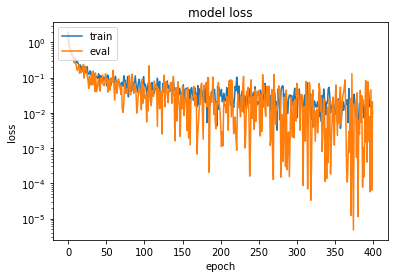

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


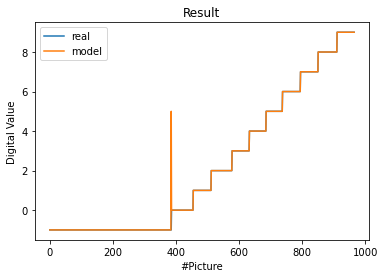

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

1302556

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8
converter2.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

337600

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.